# Nasa's Voyager 1 Data exploration using SPICE toolkit and Spiceypy (wrapper for python)

This is a hobby project where I explored NASA's Voyager 1 (the first human-made object to enter interstellar space) trajectory data using SpiceyPy, which is a Python wrapper for SPICE kernels. The space-related data is stored in kernels by NASA as they are highly efficient and optimized. I wanted to understand when it flew past each planet, how far it was from Earth at different milestones, and visualize its full 3D path through space.


What I Did
- Found the dates when Voyager 1 was closest to outer planets like Jupiter and Saturn.

- Calculated how far Voyager 1 was from Earth during each of those events.

- Included the date when Voyager 1 officially left the solar system (entered interstellar space).

- Plotted a timeline chart showing Voyager’s distance from Earth at each major event.

- Created a 3D visualization of its full trajectory in space, from Earth to its current position.

How I Did It
- I used NASA’s SPICE Toolkit, which provides precise data about spacecraft and planets.

- I worked with SpiceyPy, a Python library that makes SPICE easier to use.

- I loaded official SPICE kernels (data files) for Voyager 1 and the planets.

- Using Python, I wrote scripts to:

- Loop through dates day by day

- Get Voyager 1’s position in 3D

- Measure distances from Earth

- Plot the results using Matplotlib

## **Objective 1**: Voyager 1 3D Trajectory Relative to Earth

Importing Libraries

In [138]:
import numpy as np
import pandas as pd
import spiceypy as spice
from datetime import datetime,timedelta

Loading SPICE kernels

In [139]:
spice.furnsh('./kernels/lsk/naif0012.tls')
spice.furnsh('./kernels/spk/vgr1_jup230.bsp')
spice.furnsh('./kernels/spk/vgr1_sat337.bsp')
spice.furnsh('./kernels/spk/vgr1.x2100.bsp')
spice.furnsh('./kernels/spk/de430.bsp')
spice.furnsh('./kernels/Voyager_1.a54206u_V0.2_merged.bsp')


In [140]:
voyager_id = spice.bodn2c("VOYAGER 1")
planet_ids = {
    "Jupiter": spice.bodn2c("JUPITER BARYCENTER"),
    "Saturn": spice.bodn2c("SATURN BARYCENTER"),
    "Uranus": spice.bodn2c("URANUS BARYCENTER"),
    "Neptune": spice.bodn2c("NEPTUNE BARYCENTER"),
    "Pluto": spice.bodn2c("PLUTO BARYCENTER")
}

Setting Initial start date of the trajectory, current date and end date.

In [141]:
start_date = datetime(1977, 5, 9)
end_date = datetime(2025, 1, 1)
current_date = start_date

Setting the project scope to Voyager’s distance from Earth and extracting X,Y,Z coordinates from SPICE kernel

In [142]:
#Start and end date range


dates = []
positions = []
distances = []
# reference Document for J2000 https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/Tutorials/pdf/individual_docs/17_frames_and_coordinate_systems.pdf
# Looping through the kernel
no_data_count=0
while current_date <= end_date:
    try:
        et = spice.utc2et(current_date.strftime("%Y-%m-%dT%H:%M:%S"))
        state, _ = spice.spkez(voyager_id, et, "J2000", "NONE", 0)
        positions.append(state[:3])
        dates.append(current_date.strftime("%Y-%m"))
    except spice.stypes.SpiceyError:
        no_data_count+=1
#Extracting data for every day after the launch. Voyager -1 started sending
    current_date += timedelta(days=1) 
print(f"No Data for : {no_data_count} days")

# Converting to DataFrame
trajectory_df  = pd.DataFrame(positions, columns=["x", "y", "z"])
trajectory_df ["date"] = dates

trajectory_df .to_csv('voyager-daily-1.csv',index=False)

No Data for : 120 days


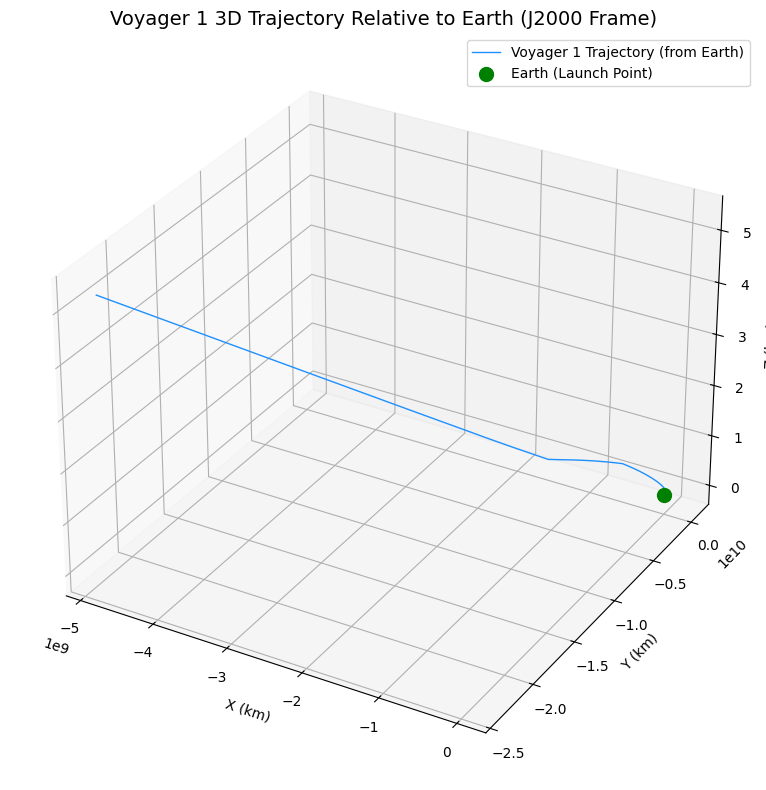

In [143]:
import matplotlib.pyplot as plt

origin = trajectory_df.loc[0, ["x", "y", "z"]].values
trajectory_df["x_rel"] = trajectory_df["x"] - origin[0]
trajectory_df["y_rel"] = trajectory_df["y"] - origin[1]
trajectory_df["z_rel"] = trajectory_df["z"] - origin[2]

# Extracting shifted coordinates
x = trajectory_df["x_rel"]
y = trajectory_df["y_rel"]
z = trajectory_df["z_rel"]

# Plotting the 3D trajectory
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x, y, z, color='dodgerblue', linewidth=1, label="Voyager 1 Trajectory (from Earth)")
ax.scatter(0, 0, 0, color='green', s=100, label='Earth (Launch Point)')

# Labels and styling
ax.set_title("Voyager 1 3D Trajectory Relative to Earth (J2000 Frame)", fontsize=14)
ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_zlabel("Z (km)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


## **OBJECTIVE 2** : Voyager 1 Milestone Distances from Earth and Major Events

Finding the closest approach date between Voyager and planets


In [144]:
def closest_approach_date(planet_id, voyager_id, start, end):
    min_dist = float('inf')
    closest_date = None
    date = start
    while date <= end:
        try:
            et = spice.utc2et(date.strftime("%Y-%m-%dT%H:%M:%S"))
            state, _ = spice.spkez(planet_id, et, "J2000", "NONE", voyager_id)
            dist = np.linalg.norm(state[:3])
            if dist < min_dist:
                min_dist = dist
                closest_date = date
        except spice.stypes.SpiceyError:
            pass
        date += timedelta(days=1)
    return closest_date


Calculating Earth-to-Voyager distance on a given date

In [145]:
def earth_to_voyager_au(date):
    try:
        et = spice.utc2et(date.strftime("%Y-%m-%dT%H:%M:%S"))
        state, _ = spice.spkez(voyager_id, et, "J2000", "NONE", 399)
        return np.linalg.norm(state[:3]) / 149597870.7  # km to AU
    except:
        return None

In [146]:
results = []

for planet, pid in planet_ids.items():
    print(f"Finding closest approach to {planet}...")
    closest = closest_approach_date(pid, voyager_id, start_date, end_date)
    if closest:
        distance = earth_to_voyager_au(closest)
        results.append({
            "Planet": planet,
            "Closest Date": closest.strftime('%Y-%m-%d'),
            "Earth–Voyager Distance (AU)": round(distance, 3)
        })

# Adding interstellar crossing manually
interstellar_date = datetime(2012, 8, 25)
interstellar_dist = earth_to_voyager_au(interstellar_date)
results.append({
    "Planet": "Entered Interstellar Space",
    "Closest Date": "2012-08-25",
    "Earth–Voyager Distance (AU)": round(interstellar_dist, 3)
})

# Output results
df = pd.DataFrame(results)
print("\nVoyager 1 Milestone Distances:")
print(df)
df.to_csv('voyager-closest-approach.csv',index=False)

Finding closest approach to Jupiter...
Finding closest approach to Saturn...
Finding closest approach to Uranus...
Finding closest approach to Neptune...
Finding closest approach to Pluto...

Voyager 1 Milestone Distances:
                       Planet Closest Date  Earth–Voyager Distance (AU)
0                     Jupiter   1979-03-06                        4.549
1                      Saturn   1980-11-13                       10.194
2                      Uranus   1983-03-28                       15.039
3                     Neptune   1985-04-10                       22.085
4                       Pluto   1986-01-30                       25.923
5  Entered Interstellar Space   2012-08-25                      121.423


In [147]:
# Manually adding earth as launch point into the dataframe
df.loc[len(df)] = {
    "Planet": "Earth (Launch)",
    "Closest Date": "1977-09-05",
    "Earth–Voyager Distance (AU)": 0.0
}

# Sort so Earth appears first
df = df.sort_values("Earth–Voyager Distance (AU)").reset_index(drop=True)


Plotting points using matplotlib

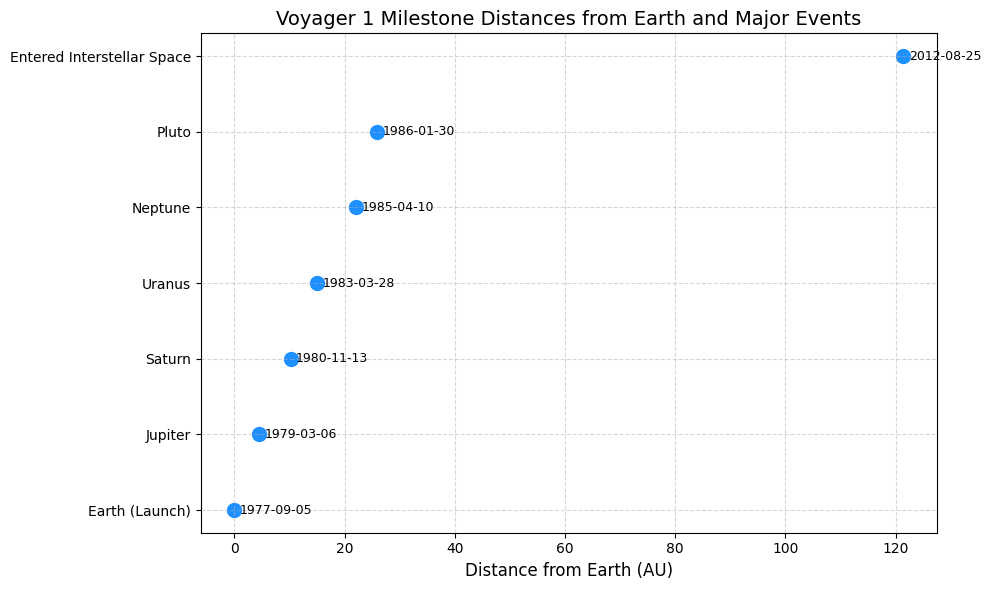

In [148]:
import matplotlib.pyplot as plt

# Setting up the plots
plt.figure(figsize=(10, 6))

# Plotting horizontal points
plt.scatter(df["Earth–Voyager Distance (AU)"], df["Planet"], s=100, color='dodgerblue')

# Adding labels next to dots
for i, row in df.iterrows():
    plt.text(row["Earth–Voyager Distance (AU)"] + 1, row["Planet"], row["Closest Date"], va='center', fontsize=9)

plt.xlabel("Distance from Earth (AU)", fontsize=12)
plt.title("Voyager 1 Milestone Distances from Earth and Major Events", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
